<a href="https://colab.research.google.com/github/jvaaguiar/Img2Mesh/blob/master/Img2Mesh_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[!] Training config (in/out)

In [0]:
from google.colab import drive
_ = drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
tarpath  = '/content/drive/\'My Drive\'/Img2Mesh/dataset/tars/'

In [0]:
# path to save checkpoints during the training
path_checkpoints_save = '/content/drive/\'My Drive\'/Img2Mesh/checkpoints/'

out_vertices = 62
hidden_size = 4096

# Requirements

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
_ = !git clone https://github.com/jvaaguiar/Img2Mesh.git
import sys
sys.path.append('/content/Img2Mesh')

# Prepare Dataset

## Fetch data

In [0]:
datapath = "/content/Img2Mesh/data"
!mkdir {datapath}

tars = !ls -1 {tarpath}
for tar in tars:
  !tar -xf {tarpath + tar} -C {datapath}

In [0]:
paths = []
for t in tars:
  paths.append(datapath + '/' + t.replace('.tar.gz', '/train'))

In [0]:
from train import prepareTrainData
X, Y = prepareTrainData(paths, ratio=1, shape='2D', lean=True)
print(X.shape)

(2588, 1, 400, 400)


## Verify models sizes in Y

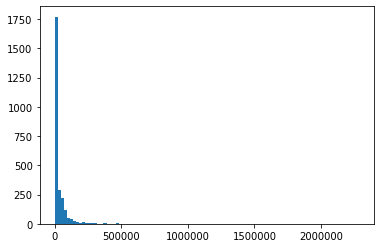

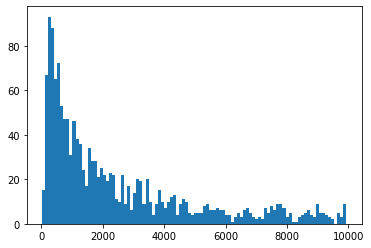

In [0]:
import matplotlib.pyplot as plt
import numpy as np
sizes = [y.shape[0] for y in Y]
sizes = np.array(sizes)
_ = plt.hist(sizes, bins=int(1e2))
plt.show()
_ = plt.hist(sizes[sizes < 1e4], bins=int(1e2))

## Downsample Y

In [0]:
from prepare_data import downsample
Y = downsample(Y, k=int(0.5e3))

# Train

In [0]:
# save the model's weights at the end of each batch

drive_chks = path_checkpoints_save + 'checkpoint.zip'
model_chks = '/content/Img2Mesh/checkpoints/'
!mkdir /content/Img2Mesh/checkpoints/

def download(path):
  _ = !zip -r {drive_chks} {path}

batches: ..........  epoch :  0  ; loss =  0.07146495580673218  ( 15.106409072875977 secs)
batches: ..........  epoch :  1  ; loss =  0.017626378685235977  ( 10.857516050338745 secs)
batches: ..........  epoch :  2  ; loss =  0.013437598943710327  ( 11.092088460922241 secs)
batches: ..........  epoch :  3  ; loss =  0.01037460658699274  ( 11.002386808395386 secs)
batches: ..........  epoch :  4  ; loss =  0.009556390345096588  ( 10.805459022521973 secs)
batches: ..........  epoch :  5  ; loss =  0.008677368052303791  ( 11.100551843643188 secs)
batches: ..........  epoch :  6  ; loss =  0.008175943978130817  ( 10.990192413330078 secs)
batches: ..........  epoch :  7  ; loss =  0.007893355563282967  ( 11.17909836769104 secs)
batches: ..........  epoch :  8  ; loss =  0.007513360120356083  ( 11.076272010803223 secs)
batches: ..........  epoch :  9  ; loss =  0.007318916730582714  ( 10.832780361175537 secs)
batches: ..........  epoch :  10  ; loss =  0.006969710346311331  ( 11.776907444000

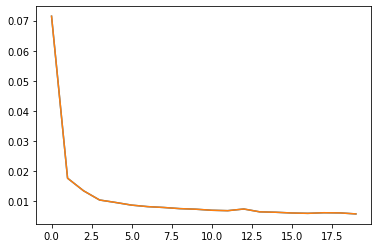

batches: ..........  epoch :  0  ; loss =  0.005819604732096195  ( 11.554772853851318 secs)
batches: ..........  epoch :  1  ; loss =  0.005693652201443911  ( 10.832734107971191 secs)
batches: .....

In [0]:
from train import saveCheckpoint
from train import runTraining, prepareNN

net, optim = prepareNN(out_verts  = out_vertices,
                       hidden_size= hidden_size,
                       model='lean',
                       learning_rate=0.001)

losses = runTraining(optim, X, Y, batch_size=int(0.05*len(X)),
                      min_error=1e-3, min_step=1e-5,
                      max_repets=10,
                      num_epochs=20,
                      checkpoint_callback=saveCheckpoint(
                          path = '/content/Img2Mesh/checkpoints/',
                          download_callback=download))

In [0]:
# the trainning can be continued using another learning rate!
from optimizer import Optimizer
optim = Optimizer(model=net,
                  learning_rate=0.0005)

losses = runTraining(optim, X, Y, batch_size=int(0.05*len(X)),
                      min_error=1e-3, min_step=1e-5,
                      max_repets=5,
                      num_epochs=20,
                      checkpoint_callback=saveCheckpoint(
                          path = '/content/Img2Mesh/checkpoints/',
                          download_callback=download))

In [0]:
# test the network for an example from the training set
import matplotlib.pyplot as plt
id = 100
y_ = net(X[id:id+1])
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(8,12))
axs[0, 0].set_xlim(0, 1), axs[0, 0].set_ylim(0, 1)

_ = axs[0, 0].scatter(y_[0][:,0],    y_[0][:,2],    c=y_[0][:,1])
_ = axs[0, 1].scatter(Y[id][:,0],    Y[id][:,2],    c=Y[id][:,1])
_ = axs[1, 0].scatter(y_[0][:,1],    y_[0][:,2],    c=y_[0][:,0])
_ = axs[1, 1].scatter(Y[id][:,1],    Y[id][:,2],    c=Y[id][:,0])
_ = axs[2, 0].scatter(y_[0][:,0],    y_[0][:,1],    c=y_[0][:,2])
_ = axs[2, 1].scatter(Y[id][:,0],    Y[id][:,1],    c=Y[id][:,2])